# SYDE 552 Assignment 2: Vision
### Due Monday, February 26, 11:59pm
### Value: 15% of total marks for the course

This assignment covers the mammilian vision system, including both questions about the biology itself and constructing computational models based on Regression and Convolutional Neural Networks.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Vision System

The purpose of this part of the assignment is to test your knowledge of the brain’s visual system and the relationship between neurobiological features and computational properties. The best answers will discuss both function and anatomy, and will draw on specific anatomical examples to support theoretical claims. You are encouraged to discuss answers with your classmates, consult the slides notes, or use external resources -- but your answers must be your own! In particular, read the Kandel et al. chapters listed on the slides. Expect to write around 5 sentences for each 1 point.

**1.a) [2 marks]** The neurons in different parts of the brain are sensitive to different things, and can be thought of as different feature detectors.  For each of the types of neurons listed below, describe what feature they detect, their receptive fields, and how their connectivity to other neurons and/or their internal neural processes helps them to do this feature detection:

- Cones

  - Cones are one of the two types of photoreceptors that are present in the eye -- they are less sensitive than rods and are primarily responsible for phototransduction in the daylight where changes in light are passed along to the brain via electrical signals. Cones have fairly small receptive fields at just one minute of arc ($\approx0.0167^{\circ}$). Cones' connections to pigment epithelium causes the change in membrane potential based on the wavelength of the photons that are within the cones' receptive fields -- this is how the phototransduction is performed. Cones also have some lateral inhibition through horizontal cells that enable phototransduction to take into account how active other cones are in the visual system. The variation in wavelength sensitivities are largely responsible for complex color representations, as there is some mixture of different cones' activities for different wavelengths.
  
- Sustained Ganglion Cells
  
  - Sustained Ganglion Cells are a subset of Ganglion cells -- cells that are largely responsible for 'detecting' edges between two differently illuminated things. These cells produce a spike train that persists for several seconds while under the same stimulii. Ganglion cells have a larger receptive field, as they take the input of several photoresistors, which are filtered through horizontal and bipolar cells.

- Transient Ganglion Cells
  
  - Transient Gangion Cells are another subset of Ganglion cells. These cells are involved with rapid changes to stimulii and the detection of their edges. Whereas the Sustained Ganglion Cells produce a spike train lasting several seconds, a Transient Gangion Cell will see its spike train die off soon after the introduction of the stimulii. Just like SGCs, TGCs have a larger receptive field than photoresistors, as they take the input of a field of photoresistors filtered through horizontal and bipolar cells.

- Simple Cells
  
  - Simple Cells are a type of orientation-sensitive perceptual neuron that has an ON and an OFF state. These cells are largely involved with the detection of orientation -- such as that of a rotated bar of light. Combinations of Simple and Complex Cells in the perceptual system are responsible for a variety of feature extractions, including depth, geometric shape, and localized motion. These cells have a much larger receptive field than Ganglion Cells, as they consider multiple regions put together to determine the nature of the stimulus they are being presented.

**1. b) [1 marks]** Describe two instances where retinotopic organization facilitates visual processing.  For each example, be sure to mention its anatomical location and discuss how retinotopy contributes to the feature detection.

- Retinotopic organization occurs in V1 -- the primary visual cortex -- and helps facilitate localized motion and pop-out of complex shapes, such as letters and numbers. Since the visual field is physically mapped to the cortex, stimulation of sections of the perceived world are processed in correlating sections of the cortex. This enable visually and physically contiguous details and features to be processed in a way that is consistent with the presentation.

- Retinotopic organization also occurs in V2 -- the secondary visual cortex -- and helps facilitate the detection of spatial patterns among other things. Since V2 receives input from V1, having a similar retinotopic structure enables it to better process spatial information. Having received some localized information about objects and motion, V2 can process their spatial relationships and enables us to detect more complex details, such as patterns. Just like in V1, the retinotopic mapping allows for consistent processing of spatial information.

**1. c) [2 marks]** Discuss the similarities and differences between convolutional neural networks and the visual system.

- Similar to the visual system, CNNs utilize a hierarchal series of feature detection layers to extract, firstly, obvious features, and later, complex features. In a similar way, the visual system has hierarchal processing of visual information from Photoreceptors to Ganglions to V1 to V2 and so on. This series of processing layers allows for the extraction of edges, shapes, motion, patterns, and so on as we get further into the visual system. Unlike the visual system, a typical CNN requires training through some optimization method and back-propagation, which is something that is not particularly biologically plausible. The visual system is not thought to undergo back-propagation and modification of neural 'weights' like CNNs. More obviously, the nodes that CNNs use to mimic neurons are not nearly as complex in their operation as biological neurons.

# 2. Classifying Stimuli Using Regression

The retina transforms the light entering an eye into a particular set of features, which are then sent to the rest of the brain for further processing.  In this section we look at how neurons might detect patterns, and how that detection changes with different feature detectors.

The data we will use for this is the classic MNIST dataset 

In [1]:
import torchvision
mnist = torchvision.datasets.MNIST(root='.', download=True)

The MNIST digits are 28x28 pixels each, each pixel is a value from 0 to 255, and there are 60,000 of them.  The raw data is in `mnist.data` and the target value (i.e. the actual digit) is in `mnist.targets`.  Here are the first 24 of each:

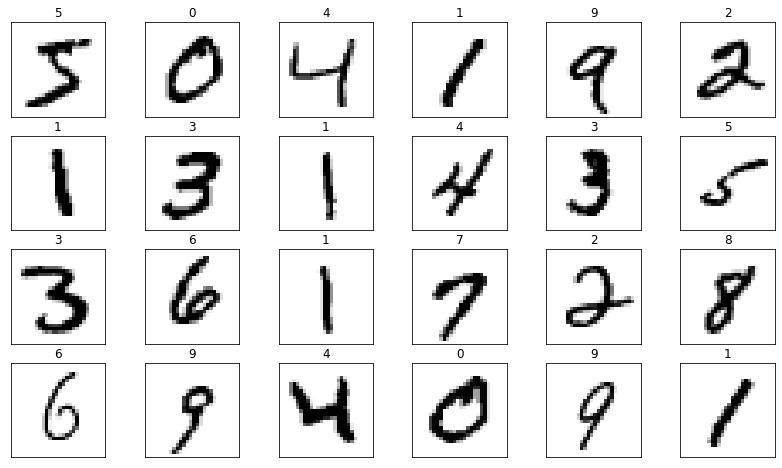

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(mnist.data[i], vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))

**2.a) [1 mark]** We can imagine the MNIST digits as 784 (28 times 28) input neurons.  We want to connect these 784 neurons to 10 output neurons, one for each digit, and see how accurately we can classify the digits.  

To find the weights in this question, we will use Ridge Regression.  `X` is the MNIST input data, divided by 255 to rescale it to between 0 and 1, and then reshaped to be a 60000x784 matrix

```
X = mnist.data.reshape((60000,28*28)).float()/255
```

The target data T is a "one-hot" representation of our outputs.  That is, instead of the desired output to be `5`, the output should be `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]` and if the desired output should be `0`, that would be `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.  

```
T = torch.nn.functional.one_hot(mnist.targets).float()
```

If our output is `Y=X @ W`, we need to find `W` such that `Y` is as close as possible to `T`.  For Ridge Regression, this is computed as

```
W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T)
```

where `I` is an identity matrix of the correct size (`torch.eye(784).float()`) and `lambd` is the $\lambda$ parameter that stops the regression from overfitting.

When building any sort of classifier model, we generally want to create the model using one set of data, and then test it on another set of data.  Here, we will use the first 5,000 data points for creating ("training") the model, and the other 55,000 for testing:

```
N = 5000
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing
```

Given this data, you should find `W` using *only* the `X_train` and `T_train` data.  Once you find `W` you can apply it to the `X_train` and `X_test` to get `Y_train` and `Y_test`

```
Y_train = X_train @ W
Y_test = X_test @ W
```

Finally, you can compute the accuracy by determining when the output is the correct category.  Here we will do this by counting when the largest output value in each row in `Y` is at the same spot as the largest output value in each row in `T`:

```
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
```

- Compute the training and testing accuracy when $\lambda=1$ and we use the first 5,000 data points as for training (and test on the remaining 55,000).  Report both numbers.  
- Do we expect the testing accuracy to be larger or smaller than the training accuracy?  Why?


In [3]:
import torch
X = mnist.data.reshape((60000,28*28)).float()/255
T = torch.nn.functional.one_hot(mnist.targets).float()

N = 5000
X_train, X_test = X[:N], X[N:]
T_train, T_test = T[:N], T[N:]

W = torch.inverse(X_train.T @ X_train + 1.0*torch.eye(28*28)) @ (X_train.T @ T_train)

Y_train = X_train @ W
Y_test = X_test @ W

accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)

print(accuracy_train)
print(accuracy_test)

tensor(0.9034)
tensor(0.8192)


The Accuracies of the above training and testing are summarized in the table below:

| Dataset | Accuracy |
| :-: | :-: |
| Training | 0.9034 |
| Testing | 0.8192 |

We would expect the training accuracy to be higher than the testing accuracy, as the ideal weights were based on the features extractable just from the training subset of the data. It is possible that there is some data skew in training that could affect testing accuracy as well, causing a strong performance for some numbers and a weaker performance for others, and some may appear more in the first 5000 and some may appear less. In an ideally, perfectly generalizable model, we would see the training accuracy and testing accuracy be approximately the same, but that is not very realistic.

**2. b) [2 marks]**  Repeat part a) but vary the value of `lambd` from $10^{-5}$ to $10^5$.   You can use a `for` loop such as `for lambd in np.logspace(-5, 5, 11):`.  

- Generate a single plot that shows the training and testing accuracy.  Make sure to label your axes and the lines on the plot.  

- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy).  
- Why does changing `lambd` affect the accuracy?  
- Why would having a large `lambd` value be good for making a biologically realistic model?

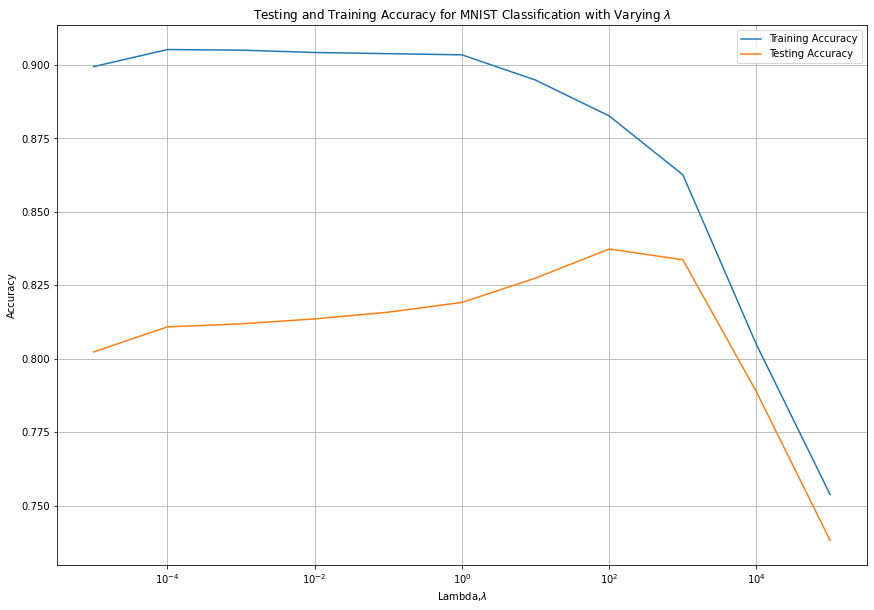

In [4]:
import numpy as np

lambdas = np.logspace(-5,5,11)
train_acc = []
test_acc = []
for l_idx in range(lambdas.shape[0]):
    W = torch.inverse(X_train.T @ X_train + lambdas[l_idx]*torch.eye(28*28)) @ (X_train.T @ T_train)
    Y_train = X_train @ W
    Y_test = X_test @ W
    train_acc.append(torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train))
    test_acc.append(torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test))

fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(right=2,top=2)
pl1.plot(lambdas,train_acc,label="Training Accuracy")
pl1.plot(lambdas,test_acc,label="Testing Accuracy")
pl1.set_xscale("log", base=10)
pl1.set_title("Testing and Training Accuracy for MNIST Classification with Varying $\lambda$")
pl1.set_xlabel("Lambda,$\lambda$")
pl1.set_ylabel("Accuracy")
pl1.legend()
pl1.grid()

With respect to the previous plot, we seem to get the best generalized performance at around $\lambda=10^{2}$ with a sharp decrease in accuracy for higher values. Changing the value of $\lambda$ directly effects the magnitudes of the weights of W, as W is the inverse of a sum involving $\lambda I$. Increasing $\lambda$ will result in a decrease in the magnitudes of these variables, causing a change in performance that is akin to decreasing the fit to the training data. This is why we see a plateau/decrease in overall training data accuracy and a mild increase to testing accuracy. The model becomes less fit to the training data and more generalizable to the testing data, though once the fit is decreased too much, both training and testing accuracy start to suffer. A high $\lambda$ is more biolgically realistic, as it reduces the "fit" of a neuron's operation to a specific dataset -- additionally, the reduction in magnitude of coefficients is more akin to how much influence each neuron has in biological classification problems.

**2. c) [1 mark]** The input we have used so far is not very realistic.  In real life, when we see written digits, they are under a wide range of lighting conditions. For this question, we change `X` by scaling it randomly and adding a random background brightness.

```
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000)[:,None]) + torch.rand(60000)[:,None]
```

To see what this looks like, here is how you can plot it:

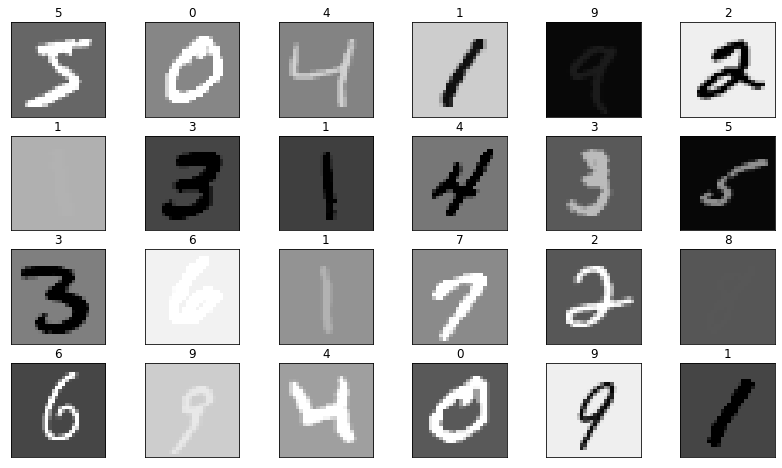

In [5]:
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(X[i].reshape(28,28), vmin=0, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))


- Generate the same plot as in 2b) but for this new dataset.  
- Is this a harder or easier task than with the original dataset?
- Is this new dataset more like the data at the retina or like the data in the ganglion cells?
- Is the original dataset more like the data at the retina or like the data in the ganglion cells?

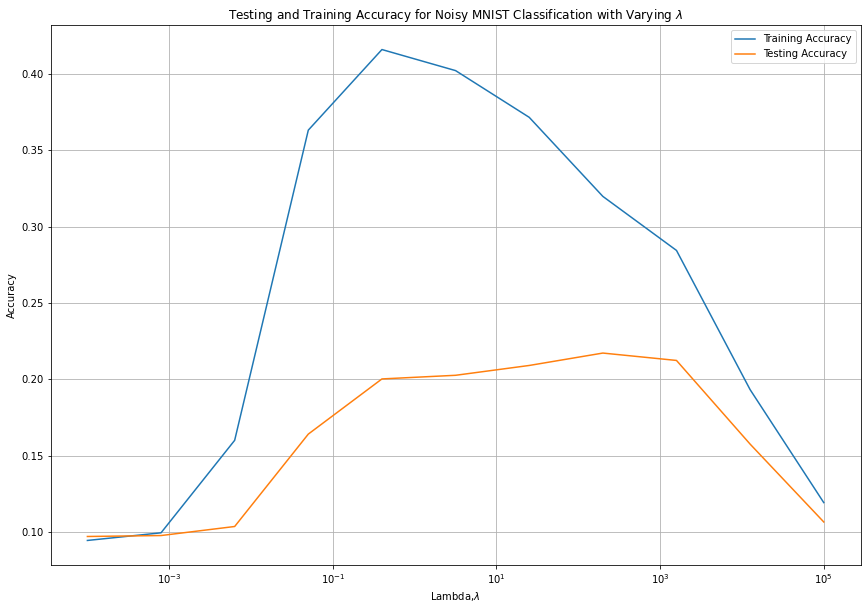

In [6]:
lambdas = np.logspace(-4,5,11) # Modified in Accordance with TA feedback
train_acc = []
test_acc = []
N = 5000
X_train, X_test = X[:N], X[N:]
T_train, T_test = T[:N], T[N:]

for l_idx in range(lambdas.shape[0]):
    W = torch.inverse(X_train.T @ X_train + lambdas[l_idx]*torch.eye(28*28)) @ (X_train.T @ T_train)
    Y_train = X_train @ W
    Y_test = X_test @ W
    train_acc.append(torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train))
    test_acc.append(torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test))

fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(right=2,top=2)
pl1.plot(lambdas,train_acc,label="Training Accuracy")
pl1.plot(lambdas,test_acc,label="Testing Accuracy")
pl1.set_xscale("log", base=10)
pl1.set_title("Testing and Training Accuracy for Noisy MNIST Classification with Varying $\lambda$")
pl1.set_xlabel("Lambda,$\lambda$")
pl1.set_ylabel("Accuracy")
pl1.legend()
pl1.grid()

The above figure indicates that classification on these noisy MNIST images is much harder than on the clean/regularized MNIST images. The new dataset is much more akin the the retinal data that cones and rods product, whereas the old dataset is much more akin to the ganglion data of edges and approximate geometry. If we were to extract the lines/edges of the new dataset into a generic representation, we would arrive at the non-modified MNIST images.

**2. d) [1 mark]** We can think of neurons in the visual system as transforming the data in various ways.  Given the dataset in 2c), neurons might be able to transform it to look more like the origin data.

Here are three data transformations that could be applied here:

Subtracting the Mean
```
X = X-torch.mean(X, axis=1)[:,None]
```

Absolute value
```
X = torch.abs(X)
```

Normalizing
```
X = X/torch.linalg.norm(X, axis=1)[:,None]
```

- Apply all three of them (in the order shown above) to the dataset and generate the same graph as in 2b) and 2c).
- How does the performance of the network compare to that of 2b) and 2c)?
- Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?
- Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?

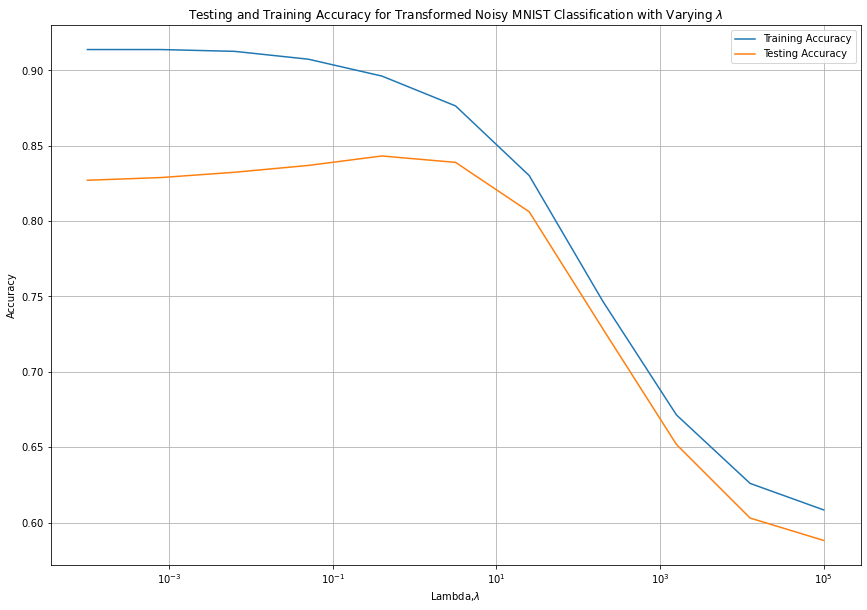

In [7]:
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]
X = X-torch.mean(X, axis=1)[:,None]
X = torch.abs(X)
X = X/torch.linalg.norm(X, axis=1)[:,None]
lambdas = np.logspace(-4,5,11) # Modified in Accordance with TA feedback
train_acc = []
test_acc = []
N = 5000
X_train, X_test = X[:N], X[N:]
T_train, T_test = T[:N], T[N:]

for l_idx in range(lambdas.shape[0]):
    W = torch.inverse(X_train.T @ X_train + lambdas[l_idx]*torch.eye(28*28)) @ (X_train.T @ T_train)
    Y_train = X_train @ W
    Y_test = X_test @ W
    train_acc.append(torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train))
    test_acc.append(torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test))

fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(right=2,top=2)
pl1.plot(lambdas,train_acc,label="Training Accuracy")
pl1.plot(lambdas,test_acc,label="Testing Accuracy")
pl1.set_xscale("log", base=10)
pl1.set_title("Testing and Training Accuracy for Transformed Noisy MNIST Classification with Varying $\lambda$")
pl1.set_xlabel("Lambda,$\lambda$")
pl1.set_ylabel("Accuracy")
pl1.legend()
pl1.grid()


# 3. Classifying Stimuli Using Backpropogation

Regression is restricted to learning the layer of weights that produces the final output.  If we want to also learn what features are most useful for producing that output, we need a more complex learning rule, and this is typically backpropogation.  Here we will classify the same data as in question 2, and we will build up different network structures to do so.

Backpropogation tends to work best when learning on a bunch of data at the same time (a "batch").  The following code will set up the same training and testing data as in question 2, but presented in randomized batches of 1000 at a time.

```python
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)
```

To create a neural network, we need to define what the weights are we will learn and we need to define the computation that the network will perform.  Here is the definition of a simple network that has an input of 784 values (the MNIST inputs), which go to 50 "hidden"-layer neurons, and then to the output 10 neurons.  So the network will learn to transform the 784 inputs into 50 new representations, and from those 50 features it will learn weights to create an output of 10 values (our 10 categories).  This is known as a multi-layer perceptron, or a standard neural network with a single hidden layer.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()
```

Finally, we need to train our model.  When training, it is useful to keep track of how well the model is doing on the testing data.  Since testing the network takes time, we don't necessarily want to do it all the time.  Instead, the following code trains the network 10 times, and then records how well the network does on the training data and on the testing data.

In [8]:
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)

class Net(torch.nn.Module):
    def __init__(self,num_hid=50):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = torch.nn.Linear(784, num_hid)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = torch.nn.Linear(num_hid, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = torch.nn.functional.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return torch.nn.functional.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()

# create the learning rule
optimizer = torch.optim.SGD(network.parameters(), 
                      lr=0.1,   # learning rate
                      momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []

def continue_training(loud=True):
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = torch.nn.functional.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    if (loud): 
        print('Iteration', len(accuracy_train), 'Training accuracy:', score)
    
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    if (loud):
        print('Iteration', len(accuracy_test), 'Testing accuracy:', score)


Given the above code, you can train your network 10 times by doing

```python
for i in range(10):
    continue_training()
```

If you want to continue training even more, you can just run that `for` loop again.

To plot the final accuracy results, you can use

```python
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()
```

**3. a) [1 mark]** Run the model above for 10 iterations (i.e. call `continue_training` 10 times).

- Plot the training and testing accuracy.  
- Is this model better or worse than the best models developed in question 2?

/tmp/ipykernel_18865/692496579.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 Training accuracy: 0.8604000210762024
Iteration 1 Testing accuracy: 0.8515999913215637
Iteration 2 Training accuracy: 0.9010000228881836
Iteration 2 Testing accuracy: 0.8867999911308289
Iteration 3 Training accuracy: 0.9156000018119812
Iteration 3 Testing accuracy: 0.8949999809265137
Iteration 4 Training accuracy: 0.9246000051498413
Iteration 4 Testing accuracy: 0.9010000228881836
Iteration 5 Training accuracy: 0.9314000010490417
Iteration 5 Testing accuracy: 0.9034000039100647
Iteration 6 Training accuracy: 0.9372000098228455
Iteration 6 Testing accuracy: 0.9053999781608582
Iteration 7 Training accuracy: 0.9404000043869019
Iteration 7 Testing accuracy: 0.9085999727249146
Iteration 8 Training accuracy: 0.946399986743927
Iteration 8 Testing accuracy: 0.9097999930381775
Iteration 9 Training accuracy: 0.9503999948501587
Iteration 9 Testing accuracy: 0.9118000268936157
Iteration 10 Training accuracy: 0.9539999961853027
Iteration 10 Testing accuracy: 0.9118000268936157


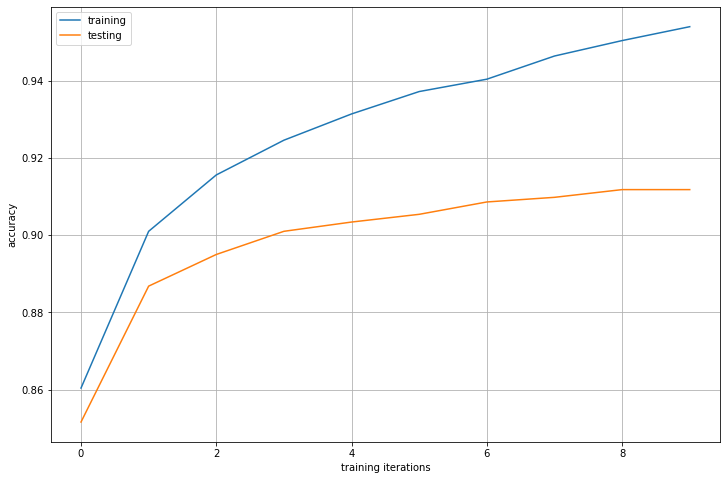

In [9]:
for _ in range(10):
    continue_training()
    
plt.figure(figsize=(12,8))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.grid()
plt.show()

We can clearly see that this model performs better than the models we explored in question 2, achieving accuracies well above 90% for both testing and training -- a benchmark that the testing data never hit in question 2.

**3. b) [1 mark]** Repeat question 3a five times.  This does not mean to run a single model for 50 iterations.  Rather, you need to reset the model and train it again.  The easiest way to do this is to recreate the network and the optimizer like this:

```python
network = Net()
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,
                      momentum=0.5)
```

- Make a plot showing the 5 different training accuracies and 5 different testing accuracies
- Also show the average training and testing accuracy on the plot.
- Each of the 5 models should show slightly different accuracies.  Why is this the case?


In [10]:
test_res = []
train_res = []
for i in range(5):
    print(f"Executing for Model {i+1}")
    accuracy_test = []
    accuracy_train = []
    network = Net()
    optimizer = torch.optim.SGD(network.parameters(),
                               lr=0.1,
                               momentum=0.5)
    for _ in range(10):
        continue_training(loud=False)
    test_res.append(accuracy_test[-1])
    train_res.append(accuracy_train[-1])

Executing for Model 1


/tmp/ipykernel_18865/692496579.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Executing for Model 2
Executing for Model 3
Executing for Model 4
Executing for Model 5


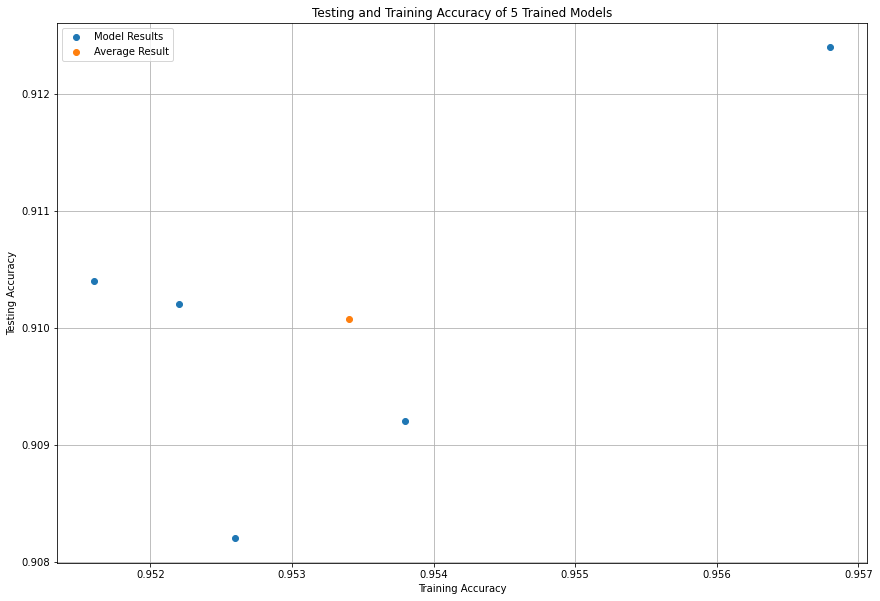

In [11]:
fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(right=2,top=2)
pl1.scatter(train_res,test_res,label="Model Results")
pl1.scatter(np.mean(train_res),np.mean(test_res),label="Average Result")
pl1.set_title("Testing and Training Accuracy of 5 Trained Models")
pl1.set_xlabel("Training Accuracy")
pl1.set_ylabel("Testing Accuracy")
pl1.legend()
pl1.grid()

The five models have very similar -- near identical -- accuracies. The maximum difference in accuracy appears to be approximately 0.005, or 0.5%. The difference could be associated with the initialization of the layer weights upon network construction. Since `Net()` uses `torch.nn.Linear`, the initial weights are sampled from a uniform distribution. This means that, assuming a random seed is not set during/before construction, the model will be initialized with differently sampled weights every time it is constructed.

**3. c) [1 mark]** Repeat question 3b varying the number of neurons in the hidden layer of the network.  The current value is 50.  Try it with 5, 10, 20, 50, and 100 neurons.  For each number of neurons, repeat five times and take the average (like in question 3b).  

- Plot the final testing accuracy on the y-axis and the number of neurons on the x-axis.  Note that to speed things up you can remove the testing computation from continue_training until the very end, since we only need the final testing score.


In [12]:
test_res = []
train_res = []
n_set = [5, 10, 20, 50, 100]
for n in n_set:
    print(f"Testing for {n} neurons")
    avg_test = []
    avg_train = []
    for i in range(5):
        print(f"\tIteration {i+1}")
        accuracy_test = []
        accuracy_train = []
        
        network = Net(num_hid=n)
        optimizer = torch.optim.SGD(network.parameters(),
                                   lr=0.1,
                                   momentum=0.5)
        for _ in range(10):
            continue_training(loud=False)
        avg_test.append(accuracy_test[-1])
        avg_train.append(accuracy_train[-1])
    test_res.append(np.mean(avg_test))
    train_res.append(np.mean(avg_train))

Testing for 5 neurons
	Iteration 1


/tmp/ipykernel_18865/692496579.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


	Iteration 2
	Iteration 3
	Iteration 4
	Iteration 5
Testing for 10 neurons
	Iteration 1
	Iteration 2
	Iteration 3
	Iteration 4
	Iteration 5
Testing for 20 neurons
	Iteration 1
	Iteration 2
	Iteration 3
	Iteration 4
	Iteration 5
Testing for 50 neurons
	Iteration 1
	Iteration 2
	Iteration 3
	Iteration 4
	Iteration 5
Testing for 100 neurons
	Iteration 1
	Iteration 2
	Iteration 3
	Iteration 4
	Iteration 5


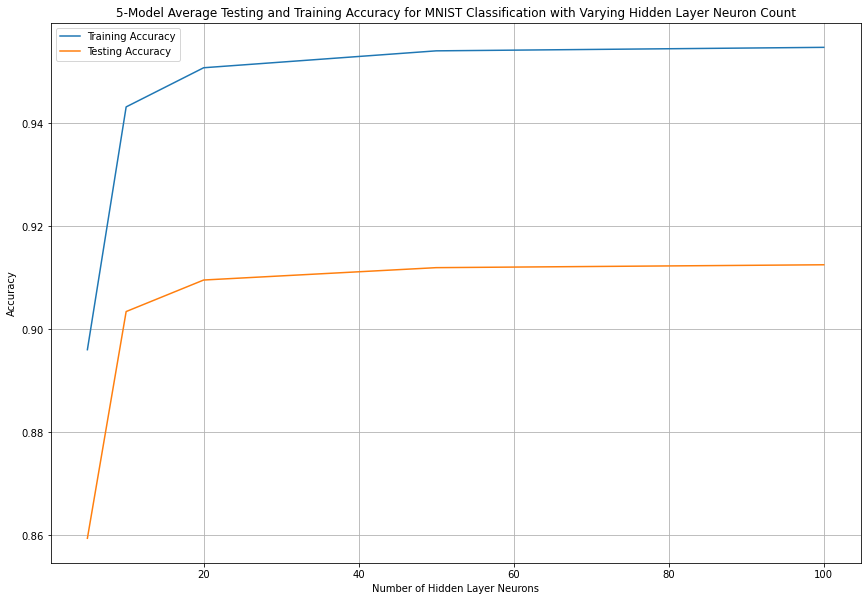

In [13]:
fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(right=2,top=2)
pl1.plot(n_set,train_res,label="Training Accuracy")
pl1.plot(n_set,test_res,label="Testing Accuracy")
pl1.set_title("5-Model Average Testing and Training Accuracy for MNIST Classification with Varying Hidden Layer Neuron Count")
pl1.set_xlabel("Number of Hidden Layer Neurons")
pl1.set_ylabel("Accuracy")
pl1.legend()
pl1.grid()

**3. d) [2 marks]** Now we will add a convolution layer to our network.  The following network adds two convolution layers before two normal neural network layers.

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
```

The following code can be used to plot the learned features in the first layer:
```python
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()
```

- Train the model through 40 iterations and generate a plot of training and testing accuracy over time.
- Does this perform better or worse than the previous models in this assignment?
- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?
- Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

Iteration 1


/tmp/ipykernel_18865/1932567801.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.log_softmax(x)


Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40


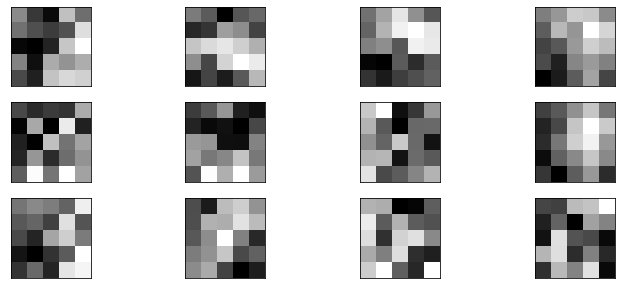

In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = torch.nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x)

network = Net()
optimizer = torch.optim.SGD(network.parameters(),
                           lr=0.1,
                           momentum=0.5)
accuracy_test = []
accuracy_train = []
for i in range(40):
    print(f"Iteration {i+1}")
    continue_training(loud=False)
    
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

**BONUS [1 mark]** Try to improve the neural network.  You want to get the best testing accuracy you can.  Try at least two different approaches and report your results.